# MLFlow Experiment Analysis

This notebook demonstrates how to fetch experiment results from MLFlow, compare runs, and visualize performance using radar charts.

In [ ]:
import mlflow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from mlflow.tracking import MlflowClient
from typing import List, Dict, Any
import dotenv

# Load environment variables from .env file
dotenv.load_dotenv(dotenv_path="../.env")

# Set tracking URI (adjust if using a remote server)
client = MlflowClient()

print(f"Tracking URI: {mlflow.get_tracking_uri()}")

Tracking URI: https://mlflow.rotary-insight.ir/


## 1. Fetching Experiment Results

We'll fetch all runs from a specific experiment or all experiments.

In [13]:
def get_runs_df(experiment_names: List[str] = None) -> pd.DataFrame:
    """Fetches runs from specified experiments and returns a DataFrame."""
    if experiment_names:
        experiment_ids = []
        for name in experiment_names:
            exp = mlflow.get_experiment_by_name(name)
            if exp:
                experiment_ids.append(exp.experiment_id)
            else:
                print(f"Warning: Experiment '{name}' not found.")
    else:
        # Fetch all experiments if none specified
        experiments = mlflow.search_experiments()
        experiment_ids = [exp.experiment_id for exp in experiments]

    if not experiment_ids:
        print("No experiments found.")
        return pd.DataFrame()

    runs = mlflow.search_runs(experiment_ids=experiment_ids)
    return runs

# Example: Fetch runs from all experiments
runs_df = get_runs_df(["no_noise_cwru_2048"])

# Display basic info
if not runs_df.empty:
    print(f"Fetched {len(runs_df)} runs.")
    display_cols = ['tags.mlflow.runName' ,'run_id', 'experiment_id', 'status', 'start_time'] 
    # Add metrics if available
    metric_cols = [c for c in runs_df.columns if c.startswith('metrics.')]
    display_cols.extend(metric_cols[:5]) # Show first 5 metrics
    
    display(runs_df[display_cols])
else:
    print("No runs found.")

Fetched 8 runs.


,tags.mlflow.runName,run_id,experiment_id,status,start_time,metrics.val_loss,metrics.train_acc,metrics.epoch_val_loss,metrics.num_params,metrics.epoch_train_loss
0,no_noise_cwru_2048__transformer_encoder_classi...,ff2989e055d6467fab045d9c93cb818a,10,FINISHED,2025-12-09 11:50:54.565000+00:00,0.001917,1.000000,0.005324,179434.0,0.000807
1,no_noise_cwru_2048__resnet1d__0,0433a2c025ac4d589e0979cb433073f0,10,FINISHED,2025-12-09 11:47:34.640000+00:00,0.006569,0.998396,0.000584,32730.0,0.012380
2,no_noise_cwru_2048__efficientnet1d__0,dacef66055ee4c6d8a7b89b86e4acb9b,10,FINISHED,2025-12-09 11:30:38.958000+00:00,0.007755,1.000000,0.001597,400106.0,0.000359
3,no_noise_cwru_2048__dpccnn__0,bc0351757d4a43d59123c93c37caa856,10,FINISHED,2025-12-09 11:26:04.012000+00:00,0.006138,1.000000,0.000290,15482.0,0.001350
4,no_noise_cwru_2048__dsicnn__0,3f195d70207e49e28629b154cfc4a1f7,10,FINISHED,2025-12-09 11:22:01.648000+00:00,0.019612,1.000000,0.000385,9658.0,0.001563
5,no_noise_cwru_2048__cnn_selfattention__0,7fc33106a0714985be0c8ecd031e8c3a,10,FINISHED,2025-12-09 11:16:30.072000+00:00,0.001494,0.999679,0.000126,2122363.0,0.002929
6,no_noise_cwru_2048__cnn_bilstm__0,90efb4591d68421a9110accc57bcfb46,10,FINISHED,2025-12-09 11:13:02.715000+00:00,0.008138,1.000000,0.004958,697738.0,0.002442
7,no_noise_cwru_2048__densenet1d__0,a8de4a1c130549faa1ba5f5b8312494b,10,FINISHED,2025-12-09 11:09:22.918000+00:00,0.008539,1.000000,0.000269,45050.0,0.001438


In [14]:
model_names = {
    "no_noise_cwru_2048__efficientnet1d__0": "EfficientNet1D",
    "no_noise_cwru_2048__dpccnn__0": "DPCCNN",
    "no_noise_cwru_2048__dsicnn__0": "DSICNN",
    "no_noise_cwru_2048__cnn_selfattention__0": "CNN+SelfAttention",
    "no_noise_cwru_2048__cnn_bilstm__0": "CNN+BiLSTM",
    "no_noise_cwru_2048__densenet1d__0": "DenseNet1D",
    "no_noise_cwru_2048__transformer_encoder_classifier__0": "TransformerEncoder",
    "no_noise_cwru_2048__resnet1d__0": "ResNet1D",
}

## 2. Comparing Runs (Detailed Table)

We'll extract detailed metrics (Precision, Recall, F1) from the `metrics.json` artifact logged for each run.

In [15]:
def get_detailed_metrics(run_id: str) -> Dict[str, Any]:
    """Downloads and parses metrics.json artifact for a run."""
    try:
        local_path = client.download_artifacts(run_id, "metrics.json", dst_path=".")
        with open(local_path, 'r') as f:
            metrics = json.load(f)
        os.remove(local_path) # Clean up
        return metrics
    except Exception as e:
        print(f"Could not fetch metrics.json for run {run_id}: {e}")
        return {}

def create_comparison_table(runs_df: pd.DataFrame) -> pd.DataFrame:
    """Creates a comparison table with Precision, Recall, and F1 Score."""
    comparison_data = []

    for _, run in runs_df.iterrows():
        run_id = run['run_id']
        
        # Basic metrics from MLFlow runs table
        entry = {
            'run_id': run_id,
            'experiment_id': run.get('experiment_id'),
            'model': model_names.get(run.get('tags.mlflow.runName', ''), run.get('params.model_name', 'N/A')),
            'val_acc': run.get('metrics.val_acc', 0),
            'val_loss': run.get('metrics.val_loss', 0),
        }

        # Detailed metrics from artifact
        detailed_metrics = get_detailed_metrics(run_id)
        if 'classification_report' in detailed_metrics:
            report = detailed_metrics['classification_report']
            # Get weighted average metrics
            if 'weighted avg' in report:
                entry['precision'] = report['weighted avg']['precision']
                entry['recall'] = report['weighted avg']['recall']
                entry['f1-score'] = report['weighted avg']['f1-score']
        
        comparison_data.append(entry)

    return pd.DataFrame(comparison_data)

if not runs_df.empty:
    comparison_df = create_comparison_table(runs_df)
    # Sort by Validation Accuracy
    comparison_df = comparison_df.sort_values(by='val_acc', ascending=False)
    display(comparison_df)
else:
    print("No runs to compare.")

31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


31e4298a9cbceb4cb419071ddfcf9bf2aae8507f3add8f67ea83ab4e45a56f43 b6fe98ec-fc94-4980-bd55-dee845c4cb88


,run_id,experiment_id,model,val_acc,val_loss,precision,recall,f1-score
0,ff2989e055d6467fab045d9c93cb818a,10,TransformerEncoder,1.000000,0.001917,1.000000,1.000000,1.000000
1,0433a2c025ac4d589e0979cb433073f0,10,ResNet1D,1.000000,0.006569,1.000000,1.000000,1.000000
2,dacef66055ee4c6d8a7b89b86e4acb9b,10,EfficientNet1D,1.000000,0.007755,1.000000,1.000000,1.000000
3,bc0351757d4a43d59123c93c37caa856,10,DPCCNN,1.000000,0.006138,1.000000,1.000000,1.000000
4,3f195d70207e49e28629b154cfc4a1f7,10,DSICNN,1.000000,0.019612,1.000000,1.000000,1.000000
5,7fc33106a0714985be0c8ecd031e8c3a,10,CNN+SelfAttention,1.000000,0.001494,1.000000,1.000000,1.000000
7,a8de4a1c130549faa1ba5f5b8312494b,10,DenseNet1D,1.000000,0.008539,1.000000,1.000000,1.000000
6,90efb4591d68421a9110accc57bcfb46,10,CNN+BiLSTM,0.998716,0.008138,0.998745,0.998716,0.998716


In [ ]:
comparison_df.to_excel("mlflow_model_comparison.xlsx")

## 3. Radar Chart Visualization

We'll visualize the performance of the top models using a radar chart, comparing Accuracy, Precision, Recall, and F1 Score.

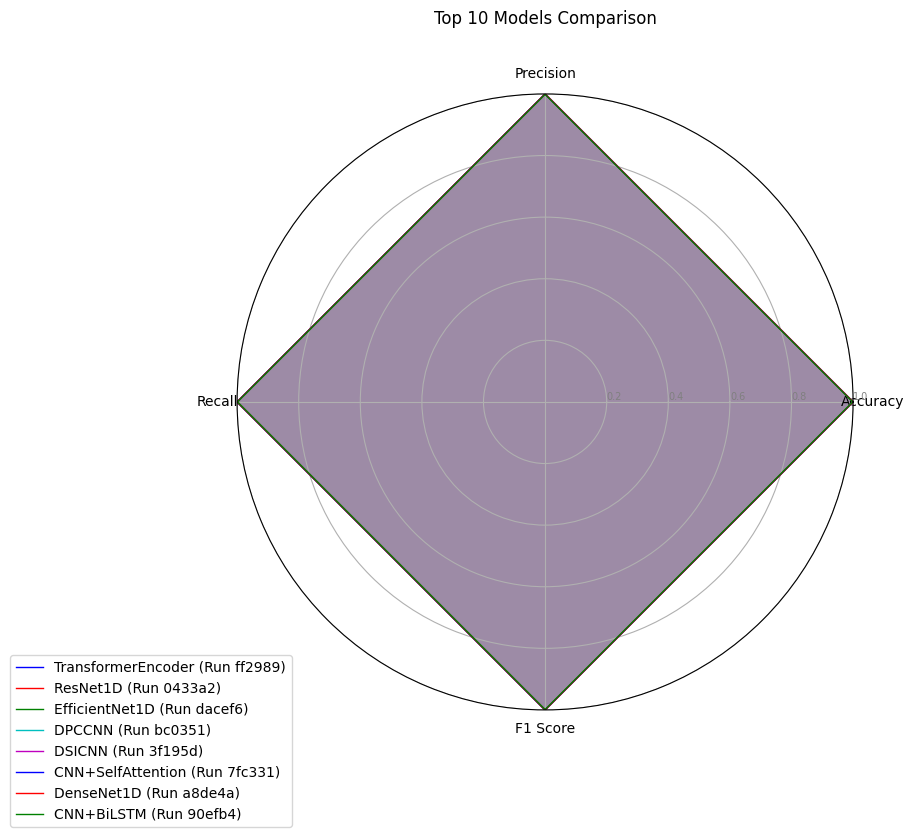

In [17]:
def plot_model_comparison(comparison_df: pd.DataFrame, top_n: int = 3):
    """Plots a radar chart comparing the top N models."""
    if comparison_df.empty:
        print("No data to plot.")
        return

    # Select top N models based on Validation Accuracy
    top_models = comparison_df.sort_values(by='val_acc', ascending=False).head(top_n)
    
    # Metrics to compare
    metrics = ['val_acc', 'precision', 'recall', 'f1-score']
    labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
    
    # Number of variables
    N = len(metrics)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1] # Close the loop
    
    # Plot
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
    # Draw axis lines
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels)
    
    # Draw y labels
    ax.set_rlabel_position(0)
    plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], ["0.2", "0.4", "0.6", "0.8", "1.0"], color="grey", size=7)
    plt.ylim(0, 1)
    
    # Plot each model
    colors = ['b', 'r', 'g', 'c', 'm']
    for i, (_, row) in enumerate(top_models.iterrows()):
        values = [row.get(m, 0) for m in metrics]
        values += values[:1] # Close the loop
        
        model_name = f"{row['model']} (Run {row['run_id'][:6]})"
        color = colors[i % len(colors)]
        
        ax.plot(angles, values, linewidth=1, linestyle='solid', label=model_name, color=color)
        ax.fill(angles, values, color, alpha=0.1)
        
    plt.title(f"Top {top_n} Models Comparison", y=1.1)
    plt.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
    plt.show()

if not runs_df.empty and not comparison_df.empty:
    plot_model_comparison(comparison_df, top_n=10)